# Check local solution

In this notebook, we want to verify the `LeafNode` object is computing an acceptable solution to the inhomogeneous Helmholtz equation. 

In [25]:
import torch
import numpy as np
import sys
import matplotlib.pyplot as plt
from scipy.interpolate import LinearNDInterpolator
# I have to do this because I'm running the notebook in the checks/ directory
sys.path.append('..')

In [5]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:

from src.interior_solution import LeafNode
from src.utils import differentiation_matrix_1d, chebyshev_points, points_to_2d_lst_of_points, get_incident_plane_waves

### Set up geometric information about the local grid, as well as a simple scattering object

In [7]:
DOMAIN_MAX = 0.5
N_CHEB_PTS = 50
N_GAUSS_PTS = 50
UPPER_LEFT_X = -0.5
UPPER_LEFT_Y = 0.5


In [8]:
x = torch.linspace(-DOMAIN_MAX, DOMAIN_MAX, N_CHEB_PTS)
pts_lst = points_to_2d_lst_of_points(x)
radii = torch.linalg.norm(pts_lst, axis=1)

scattering_obj = 1e-04 * (torch.exp(-1 * radii))
obj_for_plt = scattering_obj.numpy().reshape(N_CHEB_PTS, N_CHEB_PTS)

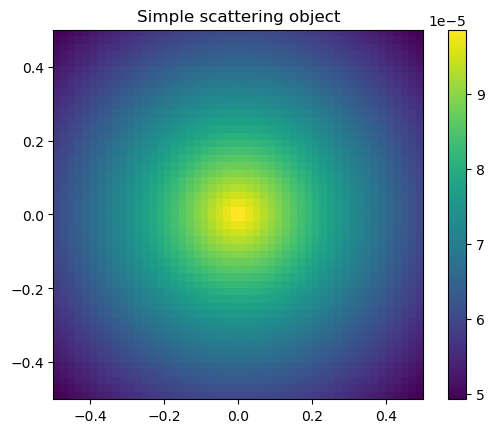

In [9]:
plt.imshow(obj_for_plt, extent=np.array([-DOMAIN_MAX, DOMAIN_MAX, -DOMAIN_MAX, DOMAIN_MAX]))
plt.colorbar()
plt.title('Simple scattering object')
plt.show()

## Set up LeafNode cell

In [22]:
omega_val = 2 * np.pi * 4
l = LeafNode(DOMAIN_MAX, N_CHEB_PTS, N_GAUSS_PTS, UPPER_LEFT_X, UPPER_LEFT_Y, omega_val, scattering_obj, pts_lst)

One thing we'd like to test is the accuracy of the interior solution created by the finite-difference approximation, which is stored in attribute `LeafNode.A`. The original PDE is 
$$ \Delta u + \omega^2( 1 - q) u = 0$$
If we decompose $u(x) = u_{in}(x) + u_{scat}(x)$ for a known incident plane wave with frequency $\omega$, then the PDE becomes:
$$\Delta u_{scat} + \omega^2(1 - q) u_{scat} = \omega^2 q u_{in}$$
We need to take the following steps:
1. Generate a plane wave with direction $s$ and frequency $\omega$ on the Chebyshev grid defined at `LeafNode.cheby_quad_obj.points_lst`.
2. Interpolate $q$ from the regular grid to the Chebyshev grid defined at `LeafNode.cheby_quad_obj.points_lst`.
3. Solve the linear system shown above to find $u_{scat}$ on the Chebyshev grid.
4. Interpolate back to the regular grid.


In [30]:
# Generate a plane wave evaluated on the Chebyshev points
s = torch.tensor([np.pi,])
plane_wave_evals = get_incident_plane_waves(s, omega_val, l.cheby_quad_obj.points_lst)

# Interpolate Q to the Chebyshev points
q_on_cheby_pts = l.cheby_quad_obj.interp_to_2d_points(pts_lst, scattering_obj)

# Set up the RHS of the system
rhs = omega_val**2 * q_on_cheby_pts.flatten() * plane_wave_evals.flatten()

print(rhs.shape)
print(l.A.shape)
# Solve the system
u_scat_on_cheby_pts = torch.linalg.solve(l.A.to(torch.complex128), rhs)
print(u_scat_on_cheby_pts.shape)


torch.Size([2500])
torch.Size([2500, 2500])
torch.Size([2500])


In [31]:
# Interpolate the solution to the regular grid
interp_obj = LinearNDInterpolator(l.cheby_quad_obj.points_lst.numpy(), u_scat_on_cheby_pts.numpy())

X, Y = torch.meshgrid(
    x, torch.flipud(x), indexing="ij"
)

u_scat_on_regular_grid = interp_obj(X.numpy(), Y.numpy())


(50, 50)


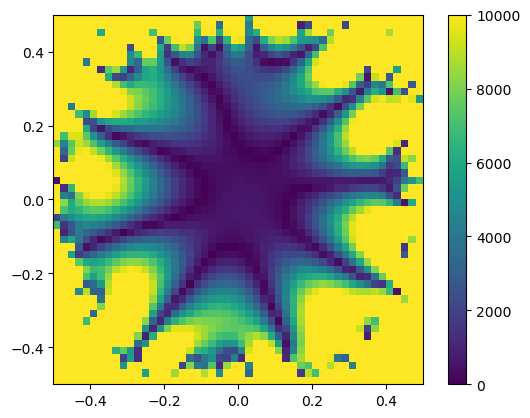

In [35]:
print(u_scat_on_regular_grid.shape)
plt.imshow(np.abs(u_scat_on_regular_grid), extent=np.array([-DOMAIN_MAX, DOMAIN_MAX, -DOMAIN_MAX, DOMAIN_MAX]))
plt.clim(0., 10_000.)
plt.colorbar()
plt.show()